In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/CNN')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/gdrive/MyDrive/Colab Notebooks/CNN


In [3]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
RAV = "/content/gdrive/MyDrive/Colab Notebooks/RAVDESS&TESS/"

In [5]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] = RAV_df.emotion
RAV_df['source'] = 'RAVDESS&TESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
# RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

fear        592
surprise    592
angry       592
sad         592
disgust     592
happy       592
neutral     496
calm        192
Name: labels, dtype: int64

In [6]:
RAV_df.labels.count()

4240

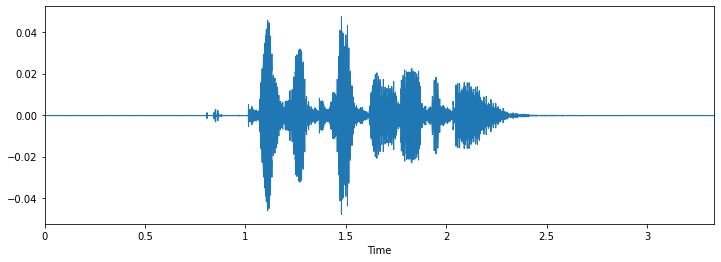

In [7]:
data, sampling_rate = librosa.load('/content/gdrive/MyDrive/Colab Notebooks/RAVDESS&TESS/Actor_01/03-01-01-01-01-02-01.wav')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

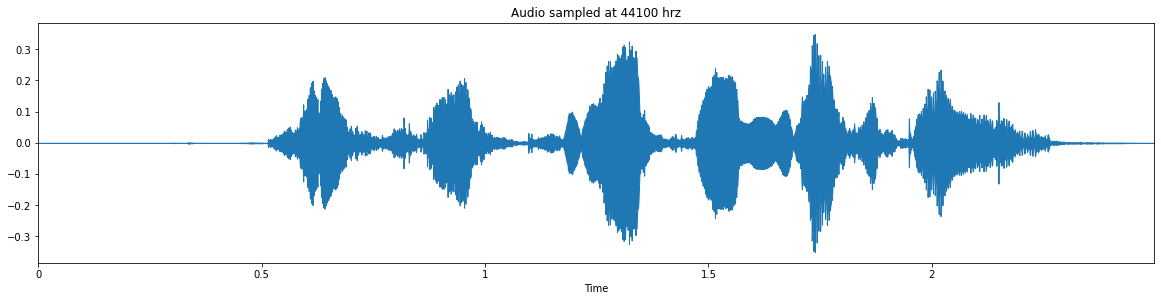

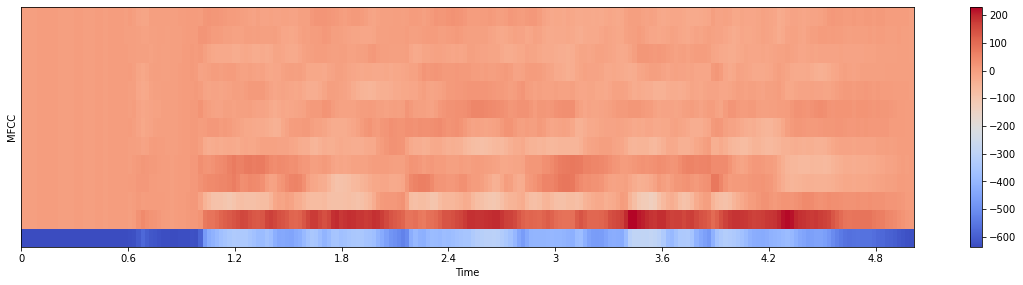

In [8]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "/content/gdrive/MyDrive/Colab Notebooks/RAVDESS&TESS/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

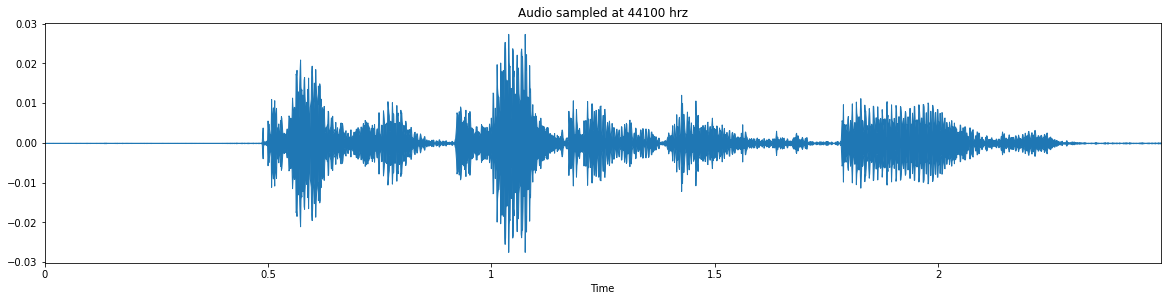

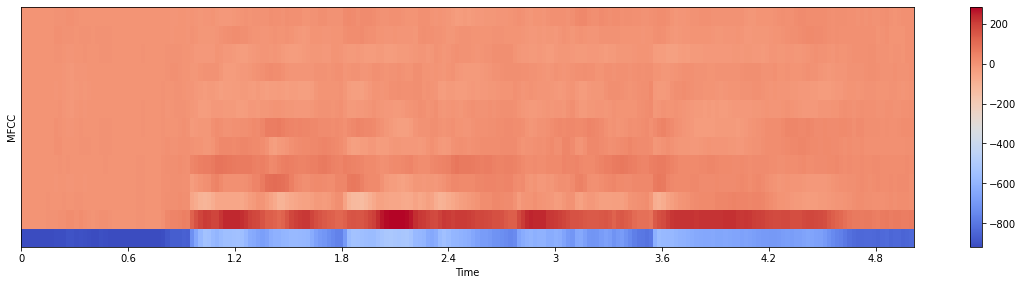

In [9]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/content/gdrive/MyDrive/Colab Notebooks/RAVDESS&TESS/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

In [10]:
import time
import os
path = '/content/gdrive/MyDrive/Colab Notebooks/RAVDESS&TESS/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 2640.060163497925 seconds ---


In [11]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [12]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)

X.shape, y.shape

((4240, 40), (4240,))

In [ ]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/gdrive/MyDrive/Colab Notebooks/CNN'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [15]:
#Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

ImportError: ignored

In [17]:
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Keras
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
# from keras.utils import to_categorical
from keras import utils as np_utils
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [18]:
# Loading saved models
import joblib
X = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/CNN/X.joblib')
y = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/CNN/y.joblib')

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=12)

In [20]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [21]:
x_traincnn.shape, x_testcnn.shape

((2968, 40, 1), (1272, 40, 1))

In [22]:
model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 64)            384       
_________________________________________________________________
activation (Activation)      (None, 40, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0

In [24]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
186/186 [==============================] - 34s 7ms/step - loss: 4.8190 - accuracy: 0.1676 - val_loss: 1.9714 - val_accuracy: 0.2862
Epoch 2/200
186/186 [==============================] - 1s 5ms/step - loss: 3.0856 - accuracy: 0.2447 - val_loss: 1.3682 - val_accuracy: 0.4937
Epoch 3/200
186/186 [==============================] - 1s 4ms/step - loss: 2.1219 - accuracy: 0.3861 - val_loss: 1.2280 - val_accuracy: 0.5613
Epoch 4/200
186/186 [==============================] - 1s 4ms/step - loss: 1.7096 - accuracy: 0.4688 - val_loss: 1.1911 - val_accuracy: 0.6124
Epoch 5/200
186/186 [==============================] - 1s 4ms/step - loss: 1.4721 - accuracy: 0.5329 - val_loss: 1.0281 - val_accuracy: 0.6855
Epoch 6/200
186/186 [==============================] - 1s 4ms/step - loss: 1.3197 - accuracy: 0.5833 - val_loss: 1.0288 - val_accuracy: 0.6659
Epoch 7/200
186/186 [==============================] - 1s 4ms/step - loss: 1.2433 - accuracy: 0.6124 - val_loss: 0.9376 - val_accuracy: 0.698

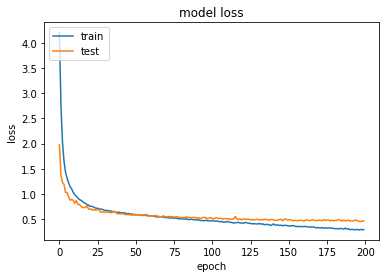

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

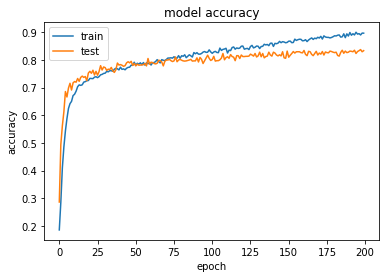

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pre = model.predict_classes(x_traincnn)
# predictions_train = model.predict(x_traincnn)
new_Ytrain = y_train.astype(int)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(pre, new_Ytrain)
print("Train Accuracy Score: {:.2f}%".format(accuracy*100))

Train Accuracy Score: 94.51%


In [ ]:
predictions_test = model.predict_classes(x_testcnn)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
accuracy = float(accuracy_score(predictions_test,new_Ytest))*100
print("----Test accuracy score %s ----" % accuracy)

----Test accuracy score 83.33333333333334 ----


In [ ]:
from sklearn.metrics import classification_report
import seaborn as sn
report = classification_report(new_Ytest, predictions_test)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       150
           1       0.65      0.76      0.70        58
           2       0.84      0.76      0.80       167
           3       0.86      0.77      0.82       172
           4       0.88      0.88      0.88       163
           5       0.89      0.84      0.86       184
           6       0.77      0.85      0.81       198
           7       0.83      0.86      0.84       180

    accuracy                           0.83      1272
   macro avg       0.82      0.83      0.82      1272
weighted avg       0.84      0.83      0.83      1272



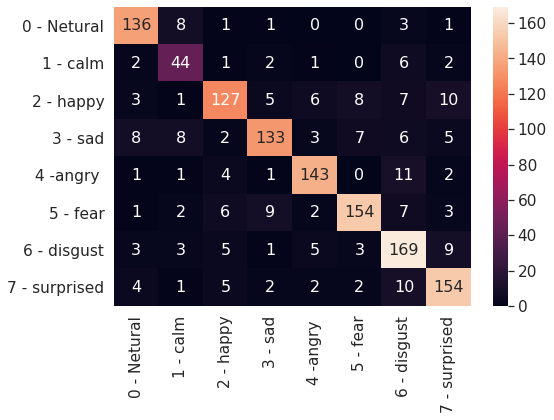

In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

labels = ['0 - Netural', '1 - calm', '2 - happy', '3 - sad', '4 -angry ', '5 - fear', '6 - disgust' , '7 - surprised']
plot_conf_matrix(new_Ytest,predictions_test,labels)

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/CNN/testing2_model.h5')
print("MODEL SAVED")

MODEL SAVED


In [ ]:
new_model=keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/CNN/testing1_model.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
activation_4 (Activation)    (None, 40, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)          

In [ ]:
loss, acc = new_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

40/40 [==============================] - 0s 2ms/step - loss: 0.2452 - accuracy: 0.9245
Restored model, accuracy: 92.45%
